# Tesseract OCR: распознавание текста на изображениях


Оптическое распознавание символов (OCR — Optical Character Recognition) это задача извлечения текста из изображений.
**Применения OCR:**
- Оцифровка отсканированных документов
- Извлечение текста из PDF файлов
- Распознавание рукописного текста
- Чтение номерных знаков автомобилей
- Обработка чеков и квитанций
- Извлечение данных из форм
- Озвучивание текста для слабовидящих
- Перевод текста с вывесок в реальном времени
- Извлечение субтитров из видео
- и другие



В этой серии из трех блокнотов мы пройдем путь эволюции технологий распознавания:

1.  **Tesseract (в этом блокноте):** Классический, проверенный временем инструмент, работающий на стыке компьютерного зрения и рекуррентных сетей.
2.  **EasyOCR:** Более современный Deep Learning подход, использующий раздельные мощные нейросети для детекции и чтения.
3.  **PaddleOCR:** SOTA (State of the Art) решение промышленного уровня, оптимизированное для высокой скорости и точности.


# Tesseract


**Tesseract** это легенда в мире OCR. Изначально разработанный HP в 1980-х, а затем выкупленный и открытый Google в 2006 году, он долгое время был золотым стандартом индустрии.

Несмотря на возраст, он остается актуальным по трем причинам:
* **Легкость:** Работает на CPU, не требуя мощных видеокарт.
* **Приватность:** Работает локально, данные никуда не отправляются.
* **Работа с документами:** Он все еще один из лучших инструментов для обработки печатного текста, в том числе "чистых" сканов документов (PDF, книги, официальные бланки).


## Как устроен Tesseract?


Чтобы получить хороший результат, важно понимать внутреннюю механику инструмента. Современный Tesseract (v4 и v5) — это **гибридная система**:

1. **Сегментация**

В отличие от современных нейросетей, которые могут найти текст где угодно (по диагонали, по кругу), Tesseract мыслит строго **"строками"**.

Он использует библиотеку *Leptonica* для предварительной обработки:
-  Делает изображение черно-белым (бинаризация).
-  Пытается выровнять страницу.
-  Нарезает изображение на отдельные горизонтальные строки.

 2. **LSTM**

Старые версии Tesseract пытались распознавать каждую букву отдельно, сравнивая её с шаблоном. Это плохо работало, если буквы слипались или были напечатаны необычным шрифтом.

Начиная с версии 4.0, Tesseract использует **LSTM (Long Short-Term Memory)** — рекуррентную нейронную сеть.
*  Сканирует строку пикселей слева направо.
*  Сеть "помнит", что было до текущего символа. Если она видит вертикальную черту `|`, она решает, что это — буква `I`, строчная `l` или цифра `1`, основываясь на соседях и языковой модели.
* Именно поэтому Tesseract требует указывать язык (`lang='rus'`) — это загружает статистику того, какие буквы чаще всего стоят рядом в конкретном языке.




В этом блокноте мы научимся:
1. Устанавливать и настраивать Tesseract
2. Распознавать текст на простых изображениях
3. Работать с различными языками
4. Поймем важность предобработки
5. Посмотрим на особенность работы с режимами сегментациии
6. Посмотрим на детальный анализ работы Tesseract

Полезные ссылки:
* [Документация Tesseract](https://tesseract-ocr.github.io/)
* [GitHub репозиторий](https://github.com/tesseract-ocr/tesseract)
* [pytesseract документация](https://pypi.org/project/pytesseract/)

## Установка

Tesseract состоит из двух частей:
1. Tesseract engine (C++ приложение)
2. pytesseract (Python обёртка)

В Colab Tesseract уже предустановлен, нужно только установить Python обёртку.

In [ ]:
# Установка pytesseract и вспомогательных библиотек
!pip install -q pytesseract pillow opencv-python matplotlib pandas

In [ ]:
# Проверка установки
!tesseract --version

tesseract 4.1.1
 leptonica-1.82.0
  libgif 5.1.9 : libjpeg 8d (libjpeg-turbo 2.1.1) : libpng 1.6.37 : libtiff 4.3.0 : zlib 1.2.11 : libwebp 1.2.2 : libopenjp2 2.4.0
 Found AVX2
 Found AVX
 Found FMA
 Found SSE
 Found libarchive 3.6.0 zlib/1.2.11 liblzma/5.2.5 bz2lib/1.0.8 liblz4/1.9.3 libzstd/1.4.8


## Установка языковых моделей

Tesseract требует языковые модели для распознавания. По умолчанию доступен английский. Установим русский и другие полезные языки.

In [ ]:
# Установка русского языка
!apt-get install -qq tesseract-ocr-rus

# Можно установить дополнительные языки:
# !apt-get install -qq tesseract-ocr-deu  # Немецкий
# !apt-get install -qq tesseract-ocr-fra  # Французский
# !apt-get install -qq tesseract-ocr-chi-sim  # Китайский упрощённый

Selecting previously unselected package tesseract-ocr-rus.
(Reading database ... 117540 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-rus_1%3a4.00~git30-7274cfa-1.1_all.deb ...
Unpacking tesseract-ocr-rus (1:4.00~git30-7274cfa-1.1) ...
Setting up tesseract-ocr-rus (1:4.00~git30-7274cfa-1.1) ...


In [ ]:
# Проверка доступных языков
!tesseract --list-langs

List of available languages (3):
eng
osd
rus


Установим шрифт с поддержкой кириллицы:

In [ ]:
!apt-get update -qq
!apt-get install -qq fonts-dejavu fonts-liberation

# Проверка установленных шрифтов
!fc-list | grep -i dejavu | head -5

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-dejavu-core.
(Reading database ... 117544 files and directories currently installed.)
Preparing to unpack .../fonts-dejavu-core_2.37-2build1_all.deb ...
Unpacking fonts-dejavu-core (2.37-2build1) ...
Selecting previously unselected package fonts-dejavu-extra.
Preparing to unpack .../fonts-dejavu-extra_2.37-2build1_all.deb ...
Unpacking fonts-dejavu-extra (2.37-2build1) ...
Selecting previously unselected package fonts-dejavu.
Preparing to unpack .../fonts-dejavu_2.37-2build1_all.deb ...
Unpacking fonts-dejavu (2.37-2build1) ...
Setting up fonts-dejavu-core (2.37-2build1) ...
Setting up fonts-dejavu-extra (2.37-2build1) ...
Setting up fonts-dejavu (2.37-2build1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
/usr/share/fonts/truetype/dejavu

# Базовое распознавание текста

Начнём с простого примера, создадим изображение с текстом и распознаем его.

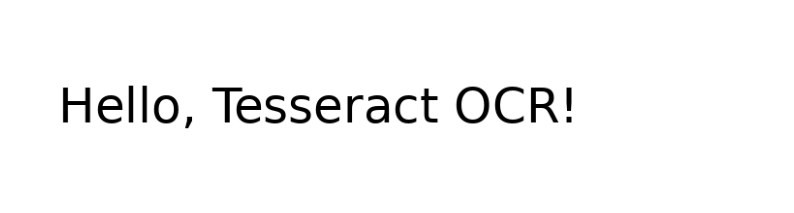

In [ ]:
# Создадим тестовое изображение с текстом
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

# Создаём белое изображение
img = Image.new('RGB', (800, 200), color='white')
draw = ImageDraw.Draw(img)

font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf", 50)

# Рисуем текст
text = "Hello, Tesseract OCR!"
draw.text((50, 70), text, fill='black', font=font)

# Сохраняем
img.save('sample_en.png')

# Показываем
plt.figure(figsize=(10, 3))
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
import pytesseract
from PIL import Image

# Загружаем изображение
image = Image.open('sample_en.png')

# Распознаём текст
text = pytesseract.image_to_string(image, lang='eng')

print("Распознанный текст:")
print(text)

Распознанный текст:
Hello, Tesseract OCR!



## Распознавание русского текста

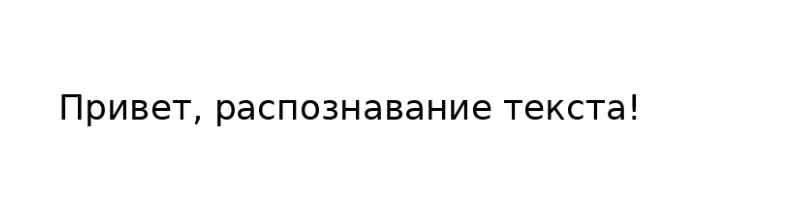

In [ ]:
# Создаём изображение с русским текстом
img = Image.new('RGB', (800, 200), color='white')
draw = ImageDraw.Draw(img)

font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf", 36)

text_ru = "Привет, распознавание текста!"
draw.text((50, 80), text_ru, fill='black', font=font)

img.save('sample_ru.png')

plt.figure(figsize=(10, 3))
plt.imshow(img)
plt.axis('off')
plt.show()

Распознавание с указанием русского языка


In [ ]:
image = Image.open('sample_ru.png')
text = pytesseract.image_to_string(image, lang='rus')

print("Распознанный русский текст:")
print(text)

Распознанный русский текст:
Привет, распознавание текста!



Можно комбинировать языки:


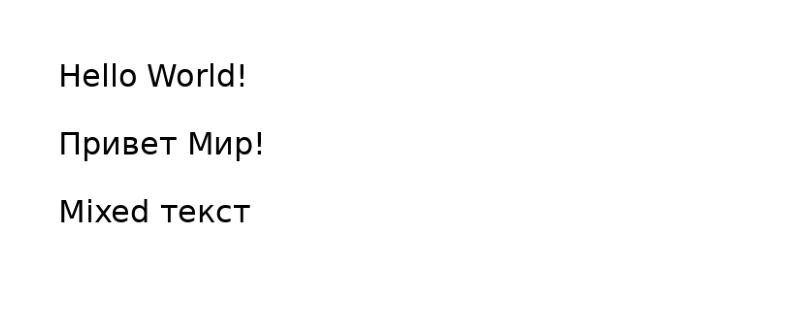

Распознанный текст (eng+rus):
Hello World!
Привет Мир!

Mixed TekcT



In [ ]:
img = Image.new('RGB', (800, 300), color='white')
draw = ImageDraw.Draw(img)

font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf", 32)

draw.text((50, 50), "Hello World!", fill='black', font=font)
draw.text((50, 120), "Привет Мир!", fill='black', font=font)
draw.text((50, 190), "Mixed текст", fill='black', font=font)

img.save('sample_mixed.png')

plt.figure(figsize=(10, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

image = Image.open('sample_mixed.png')
text = pytesseract.image_to_string(image, lang='eng+rus')

print("Распознанный текст (eng+rus):")
print(text)

# Предобработка изображений


Обычно, пайплайн Tesseract выглядит так:

`Очистка изображения -> Поиск строк -> Чтение последовательности (LSTM)`

Если ломается первый этап (плохая картинка или недостаточный препроцессинг), ломается всё.

Качество распознавания сильно зависит от качества изображения. Рассмотрим типичные техники предобработки:

1. Масштабирование — увеличение маленьких изображений
2. Бинаризация — перевод в чёрно-белое изображение
3. Удаление шума — фильтрация помех
4. Коррекция наклона — выравнивание текста
5. Повышение контраста

Поэтому важно понимать каике данные мы ожидаем и делать соответствующую предобработку, посмотрим на примере повернутого текста:

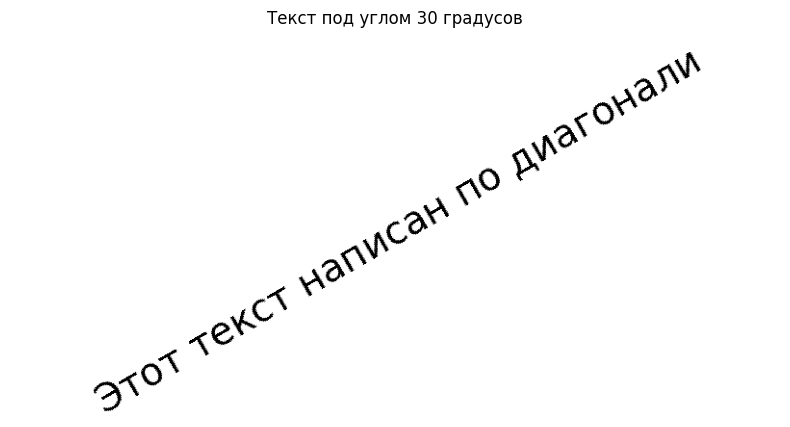

Распознанный текст: ''


In [ ]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import pytesseract
import numpy as np

# 1. Создаём изображение
w, h = 800, 400
img = Image.new('RGB', (w, h), color='white')
draw = ImageDraw.Draw(img)

font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf", 40)

text_ru = "Этот текст написан по диагонали"
# Вычисляем размер текста, чтобы отцентрировать
text_bbox = draw.textbbox((0, 0), text_ru, font=font)
text_w = text_bbox[2] - text_bbox[0]
text_h = text_bbox[3] - text_bbox[1]
draw.text(((w - text_w) // 2, (h - text_h) // 2), text_ru, fill='black', font=font)

# Поворачиваем изображение
angle = 30  # Угол поворота
img_rotated = img.rotate(angle, expand=False, fillcolor='white')

# Сохраняем и показываем
img_rotated.save('sample_diagonal.png')

plt.figure(figsize=(10, 5))
plt.imshow(img_rotated)
plt.axis('off')
plt.title(f'Текст под углом {angle} градусов')
plt.show()

text = pytesseract.image_to_string(img_rotated, lang='rus')

print(f"Распознанный текст: '{text}'")

Как видим Tesseract ничего не распознал

# Обработка чека

Создадим более реалистичный пример: извлечение информации из чека. Например, мы хотим извлечь информацию о товарах и ценах и структурировать ее.

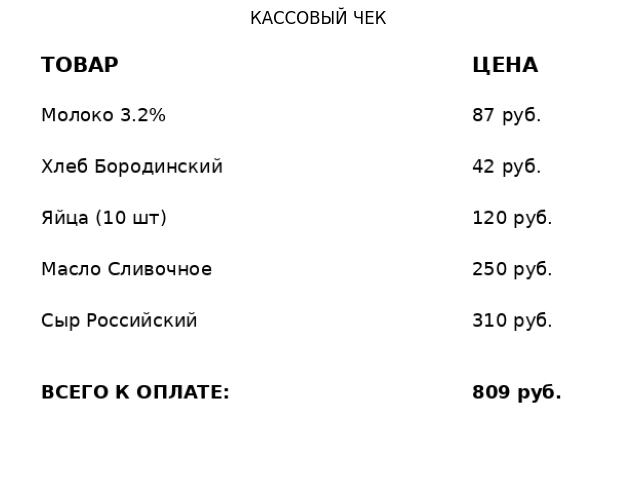

In [ ]:
import pytesseract
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

img = Image.new('RGB', (600, 450), color='white')
draw = ImageDraw.Draw(img)


font_header = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", 20)
font_item = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf", 18)
font_total = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", 18)

# Заголовки
draw.text((30, 20), "ТОВАР", fill='black', font=font_header)
draw.text((450, 20), "ЦЕНА", fill='black', font=font_header)

items = [
    ("Молоко 3.2%", "87 руб."),
    ("Хлеб Бородинский", "42 руб."),
    ("Яйца (10 шт)", "120 руб."),
    ("Масло Сливочное", "250 руб."),
    ("Сыр Российский", "310 руб.")
]

y = 70
for item, price in items:
    # Левая колонка
    draw.text((30, y), item, fill='black', font=font_item)
    # Правая колонка
    draw.text((450, y), price, fill='black', font=font_item)
    y += 50

# ИТОГО
y += 20
draw.text((30, y), "ВСЕГО К ОПЛАТЕ:", fill='black', font=font_total)
draw.text((450, y), "809 руб.", fill='black', font=font_total)

# Сохраняем
img.save('receipt.png')

plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.axis('off')
plt.title('КАССОВЫЙ ЧЕК')
plt.show()


Если мы запустим Tesseract по умолчанию, то увидим что в данном примере он рассматривает чек не по строкам, как можно было ожидать, а по столбцам. Для нас это критично, потому что мы хотим сопоставить товар цене и при таком распозновании задача парсинга кратно усложняется. Любая ошибка нераспознования ломает весь матчинг пар `товар:цена`.

In [ ]:
text = pytesseract.image_to_string(img, lang='rus')
print("--- Результат распознавания ---")
print("\n" + "="*50 + "\n")
print(text)
print("\n" + "="*50 + "\n")



--- Результат распознавания ---


ТОВАР

Молоко 3.2%
Хлеб Бородинский
Яйца (10 шт)
Масло Сливочное

Сыр Российский

ВСЕГО К ОПЛАТЕ:

ЦЕНА
87 руб.
42 руб.
120 руб.
250 руб.

310 руб.

809 руб.





Дело в режиме сегментации, по умолчанию используется полностью автоматическая сегментация страниц (Fully Automatic Page Segmentation, But No OSD) параметр `config=--psm 3`.

В этом режиме Tesseract автоматически попытается сегментировать текст, рассматривая его как "страницу" текста с несколькими словами, несколькими строками, несколькими абзацами и т. д.
после сегментации Tesseract распознает текст и вернет его вам.
Поэтому изменим его на `config=--psm 6`

In [ ]:
text = pytesseract.image_to_string(img, lang='rus', config='--psm 6')
print("--- Результат распознавания ---")
print("\n" + "="*50 + "\n")
print(text)
print("\n" + "="*50 + "\n")

--- Результат распознавания ---


ТОВАР ЦЕНА
Молоко 3.2% 87 руб.
Хлеб Бородинский 42 руб.
Яйца (10 шт) 120 руб.
Масло Сливочное 250 руб.
Сыр Российский 310 руб.
ВСЕГО К ОПЛАТЕ: 809 руб.





Теперь мы сканируем чек построчно, и нам будет легче его обработать.

## Режимы сегментации страницы (PSM)

По умолчанию (`--psm 3`) Tesseract пытается быть "слишком умным", он ищет колонки, врезки, картинки и заголовки. Иногда это мешает, и нам нужно принудительно указать ему структуру документа.

Ниже разбор самых важных режимов по сценариям использования:


1. Автоматические режимы (Для полных страниц)

* **`--psm 3` (По умолчанию): "Газетная страница"**
    * **Как это работает:** Tesseract ищет колонки. Если он видит большой пробел посередине страницы, он решает, что это две разные статьи (как в газете), и читает сначала левую колонку до низу, а потом правую.
    * **Где ломается:** На чеках и таблицах (разрывает связь между товаром слева и ценой справа).
    
* **`--psm 1` : "Автопилот + Проверка поворота"**
    * **Как это работает:** То же, что и PSM 3, но сначала проверяет ориентацию страницы (OSD). Если скан перевернут вверх ногами или на 90°, он попытается это исправить.
    
* **`--psm 0` : "Только посмотреть"**
    * **Как это работает:** Не читает текст. Только выдает мета-информацию: ориентация страницы, название скрипта (языка), уверенность в ориентации.

2. Блочные режимы (Для таблиц, чеков и списков)

* **`--psm 6` : "Единый блок"**
    * **Как это работает:** Tesseract отключает поиск сложной структуры и колонок. Он просто читает страницу строго сверху вниз, строку за строкой.
    * **Применение:** Чеки, списки товаров, логи, фрагменты кода. Именно этот режим "чинит" проблему с чтением цен в чеках.

* **`--psm 4` : "Таблица / Excel"**
    * **Как это работает:** Считает текст одной колонкой, но допускает, что размеры шрифта могут прыгать (заголовки, примечания).
    * **Применение:** Табличные данные (Spreadsheets).

3. Режимы для фрагментов (Когда вы уже вырезали текст)

Если вы используете детектор (например, YOLO или OpenCV) для поиска текста, а Tesseract только для чтения:

* **`--psm 7` : "Одна строка"**
    * **Как это работает:** Ожидает увидеть ровно одну строку текста.
    * **Применение:** Автомобильные номера, вырезанные ценники.
    
* **`--psm 8` : "Одно слово"**
    * **Как это работает:** Ожидает одно слово. Не пытается искать пробелы.
    * **Применение:** Капча, конкретные поля анкеты (Фамилия).

4. Специальный режим

* **`--psm 11` : "Найти всё, что можно"**
    * **Как это работает:** Ищет текст "вразброс", не пытаясь выстроить порядок чтения.
    * **Применение:** Карты, схемы, скриншоты сайтов, диаграммы.


# Детальная информация о распознавании

Tesseract может предоставлять не только текст, но и дополнительную информацию: координаты слов, уровень уверенности, структуру документа.

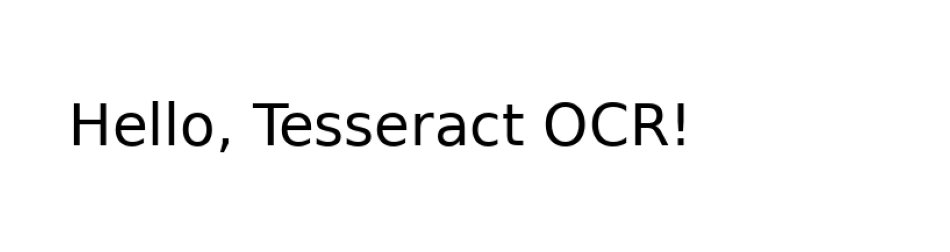

Распознанные слова с координатами и уверенностью:

     text  left  top  width  height  conf
   Hello,    55   79    133      44    95
Tesseract   209   81    232      37    96
     OCR!   461   80    119      38    96


In [ ]:
import pandas as pd

# Используем простое изображение
image = Image.open('sample_en.png')

# Получаем детальные данные
data = pytesseract.image_to_data(image, lang='eng', output_type=pytesseract.Output.DICT)

# Создаём DataFrame для удобства
df = pd.DataFrame(data)

# Фильтруем только слова (conf != -1)
words_df = df[df['conf'] != -1]

plt.figure(figsize=(12, 4))
plt.imshow(image)
plt.axis('off')
plt.show()

print("Распознанные слова с координатами и уверенностью:\n")
print(words_df[['text', 'left', 'top', 'width', 'height', 'conf']].to_string(index=False))

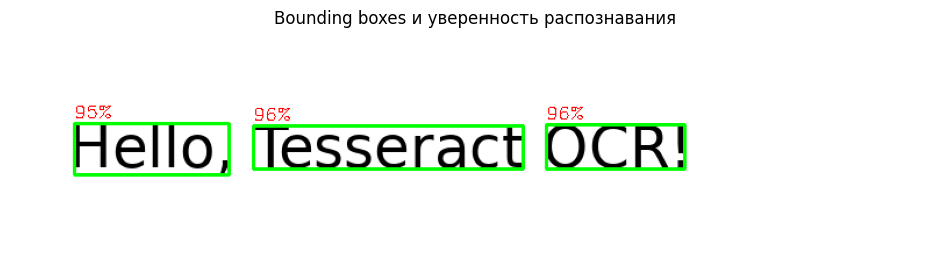

In [ ]:
# Визуализация bounding boxes
import cv2

# Загружаем изображение
img = cv2.imread('sample_en.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Рисуем bounding boxes для каждого слова
n_boxes = len(data['text'])
for i in range(n_boxes):
    if int(data['conf'][i]) > 0:  # Только если уверенность > 0
        (x, y, w, h) = (data['left'][i], data['top'][i],
                        data['width'][i], data['height'][i])

        # Рисуем прямоугольник
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # Добавляем текст с уверенностью
        conf = data['conf'][i]
        cv2.putText(img, f"{conf}%", (x, y - 5),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

# Показываем результат
plt.figure(figsize=(12, 4))
plt.imshow(img)
plt.axis('off')
plt.title('Bounding boxes и уверенность распознавания')
plt.show()

### Анализ качества распознавания на примере чека


В реальных задачах мало просто получить текст. Нам нужно знать, **насколько модель уверена** в том, что она прочитала.

Tesseract для каждого слова возвращает метрику **Confidence (уверенность)** по шкале от 0 до 100. Это важно для построения автоматизированных конвейеров:
* **Высокая уверенность (>90%):** Данные можно принимать автоматически.
* **Низкая уверенность (<50-70%):** Документ нужно отправить на ручную проверку или более сложную логику обработки.

Вместо функции `image_to_string` мы используем `image_to_data`, которая возвращает словарь с полной информацией: координаты слов, номера строк и уровень уверенности.


Статистика уверенности распознавания:
  Средняя: 95.4%
  Минимальная: 86%
  Максимальная: 96%


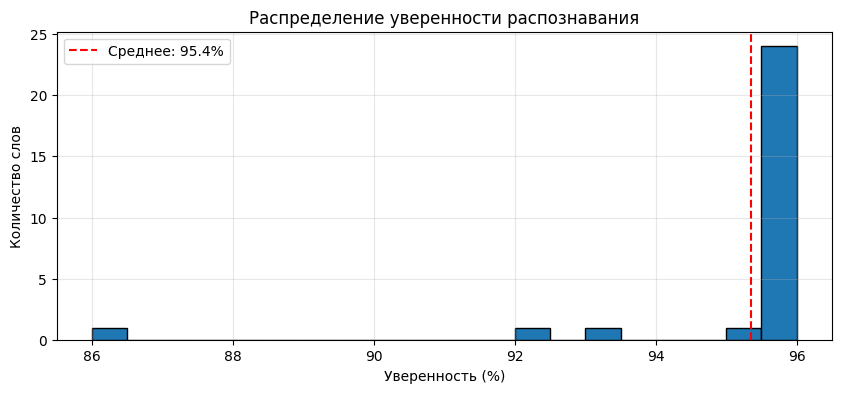


Слова с уверенностью < 95%:
  '3.2%' - 95%
  'Хлеб' - 93%
  'Бородинский' - 92%
  'Сыр' - 86%


In [ ]:
# Получаем детальные данные с уверенностью
image = Image.open('receipt.png')
data = pytesseract.image_to_data(image, lang='rus', output_type=pytesseract.Output.DICT)

# Анализируем уверенность
confidences = [int(conf) for conf in data['conf'] if int(conf) != -1]

if confidences:
    avg_conf = np.mean(confidences)
    min_conf = np.min(confidences)
    max_conf = np.max(confidences)

    print(f"Статистика уверенности распознавания:")
    print(f"  Средняя: {avg_conf:.1f}%")
    print(f"  Минимальная: {min_conf}%")
    print(f"  Максимальная: {max_conf}%")

    # Визуализация распределения
    plt.figure(figsize=(10, 4))
    plt.hist(confidences, bins=20, edgecolor='black')
    plt.xlabel('Уверенность (%)')
    plt.ylabel('Количество слов')
    plt.title('Распределение уверенности распознавания')
    plt.axvline(avg_conf, color='red', linestyle='--', label=f'Среднее: {avg_conf:.1f}%')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    # Слова с низкой уверенностью
    low_conf_threshold = 95
    low_conf_words = [(data['text'][i], data['conf'][i])
                      for i in range(len(data['text']))
                      if int(data['conf'][i]) <= low_conf_threshold and int(data['conf'][i]) != -1]

    if low_conf_words:
        print(f"\nСлова с уверенностью < {low_conf_threshold}%:")
        for word, conf in low_conf_words:
            print(f"  '{word}' - {conf}%")

## Ограничения Tesseract

**Не подходит для:**

1. Рукописного текста, часто точность очень низкая
2. Сильно стилизованных шрифтов
3. Текста с очень низким разрешением
4. Сильно искажённых изображений
5. Текста на неоднородном фоне (например, на фотографиях)

**Когда Tesseract хорош:**

- Качественные сканы документов
- Печатный текст стандартных шрифтов
- Большие объёмы данных (бесплатно)
- Нужна локальная обработка без отправки в облако
- Требуется поддержка редких языков

# Заключение

Главные выводы:

1.  **Tesseract это инструмент для "чистых" данных.**
    Он идеально подходит для сканов документов, книг и справок. Но чтобы он работал хорошо, ему нужна помощь: качественный препроцессинг (OpenCV), правильная бинаризация и удаление шума.

2.  **Настройки решают всё (PSM & OEM).**
    Мы увидели на практике, как режим сегментации (`--psm 6`) спасает данные, когда стандартный режим (`--psm 3`) ломает структуру таблицы. Понимание того, *как* алгоритм видит страницу это ключ к успеху.

3.  **OCR никогда не бывает идеальным.**
    Даже с лучшими настройками модель может спутать `3` и `З`, `0` и `О`. Поэтому важно учитывать эти ошибки в логике пайплайна




Полезные ресурсы:

- [Tesseract документация](https://tesseract-ocr.github.io/)
- [pytesseract на PyPI](https://pypi.org/project/pytesseract/)
- [Улучшение качества распознавания](https://tesseract-ocr.github.io/tessdoc/ImproveQuality.html)
- [Обучение Tesseract](https://tesseract-ocr.github.io/tessdoc/TrainingTesseract-4.00.html)
